In [27]:
# Amazon Yorumları için Duygu Analizi (Metin Madenciliği)

In [28]:
# İŞ PROBLEMİ

In [29]:
# Amazon üzerinden satışlarını gerçekleştiren ev tekstili ve günlük giyim odaklı üretimler yapan Kozmos,
# ürünlerine gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlarını
# artırmayı hedeflemektedir. Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlenecek ve etiketlenen
# veri ile sınıflandırma modeli oluşturulacaktır.

In [30]:
# VERİ SETİ HİKAYESİ

In [31]:
# Veri seti belirli bir ürün grubuna ait yapılan yorumları, yorum başlığını, yıldız sayısını ve yapılan yorumu
# kaç kişinin faydalı bulduğunu belirten değişkenlerden oluşmaktadır.

In [32]:
# 4 Değişken - 5611 Gözlem - 489 KB

In [33]:
# Star : Ürüne verilen yıldız sayısı
# Helpful : Yorumu faydalı bulan kişi sayısı
# Title : Yorum içeriğine verilen başlık, kısa yorum
# Review : Ürüne yapılan yorum

In [34]:
#########################################################
# 1. KÜTÜPHANELERİN YÜKLENMESİ
#########################################################

In [35]:
import pandas as pd
import numpy as np

import re

import nltk

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import precision_score, recall_score, f1_score

In [36]:
pd.set_option("display.width", 200)   # Çıktı genişliği 200 karakter

In [37]:
#########################################################
# 2. VERİYİ OKUMA
#########################################################

In [38]:
# Excel dosyasını okutma
df = pd.read_excel("/content/amazon.xlsx")  # amazon.xlsx dosyasını DataFrame olarak okuyalım

In [39]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [40]:
#########################################################
# 3. NLP ARAÇLARININ YÜKLENMESİ
#########################################################

In [41]:
# NLTK verilerini indir (tokenization, stopwords ve lematization için)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")  # SentimentIntensityAnalyzer için gerekli sözlük

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [42]:
# Stopword listesi ve lemmatizer tanımı
stop_words = set(stopwords.words("english"))  # Bilgi taşımayan kelimeler
lemmatizer = WordNetLemmatizer()  # Kelimeleri kök (Lemma) formuna çevirir

In [43]:
#########################################################
# 4. VERİ ÖN İŞLEME (Temizleme Fonksiyonu)
#########################################################

In [44]:
def clean_review(text):
  text = str(text).lower()   # Tüm harfleri küçük yap
  text = re.sub(r"[^\w\s]", "", text)   # Noktalama işaretlerini çıkar
  text = re.sub(r"\d+", "", text)   # Sayıları çıkar
  words = [word for word in text.split() if word not in stop_words]   # Stopword'leri çıkar ve kelimeleri liste haline getir
  words = [lemmatizer.lemmatize(word) for word in words]    # Kelimeleri kök formuna çevir
  return words


In [45]:
# Temizlenmiş kelimeleri yeni bir sütuna ekleyelim
df["clean_words"] = df["Review"].apply(clean_review)

In [46]:
#########################################################
# 5. KELİME FREKANSI ANALİZİ
#########################################################

In [47]:
# Tüm yorumlarda geçen kelimeleri sayalım
all_words = [word for tokens in df["clean_words"] for word in tokens]
word_counts = Counter(all_words)


# En sık kullanılan 20 kelimeyi al
top_20_words = word_counts.most_common(20)
print(top_20_words)

[('curtain', 2588), ('look', 1531), ('love', 1453), ('room', 1129), ('like', 1053), ('beautiful', 943), ('great', 921), ('quality', 889), ('color', 787), ('picture', 719), ('nice', 707), ('light', 606), ('material', 565), ('good', 536), ('really', 447), ('window', 429), ('would', 427), ('perfect', 423), ('one', 422), ('well', 409)]


In [48]:
# 1'den az veya eşit olan nadir kelimeleri belirleyelim
rare_words = {word for word, count in word_counts.items() if count <= 1}

In [49]:
# clean_words içinden nadir kelimeleri çıkar
df["clean_words"] = df["clean_words"].apply(
    lambda words: [word for word in words if word not in rare_words]
)

In [50]:
# İlk 5 temizlenmiş sonucu incele
df[["Review", "clean_words"]].head()

,Review,clean_words
0,Happy with it,[happy]
1,Good quality material however the panels are m...,"[good, quality, material, however, panel]"
2,Product was fun for bedroom windows.<br />Imag...,"[product, fun, bedroom, windowsbr, imagery, bi..."
3,Lo unico que me gustaria es que sean un poco ...,"[lo, que, e, que, un, poco, ma]"
4,Great bang for the buck I can't believe the qu...,"[great, bang, buck, cant, believe, quality, ma..."


In [51]:
#########################################################
# 6. FREKANS VE WORDCLOUD GÖRSELLEŞTİRME
#########################################################

In [52]:
# Dataframe'e çevirelim word_counts'u
tf = pd.DataFrame(word_counts.items(), columns=["words", "tf"])  # Sütun isimlerini words ve tf yaptık
tf_top = tf[tf["tf"] > 500]
print(tf_top)

         words    tf
1         good   536
2      quality   889
3     material   565
29       great   921
35       color   787
42        look  1531
51     picture   719
53     curtain  2588
56        nice   707
91        room  1129
103      light   606
117       love  1453
149  beautiful   943
165       like  1053


/tmp/ipython-input-468463047.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


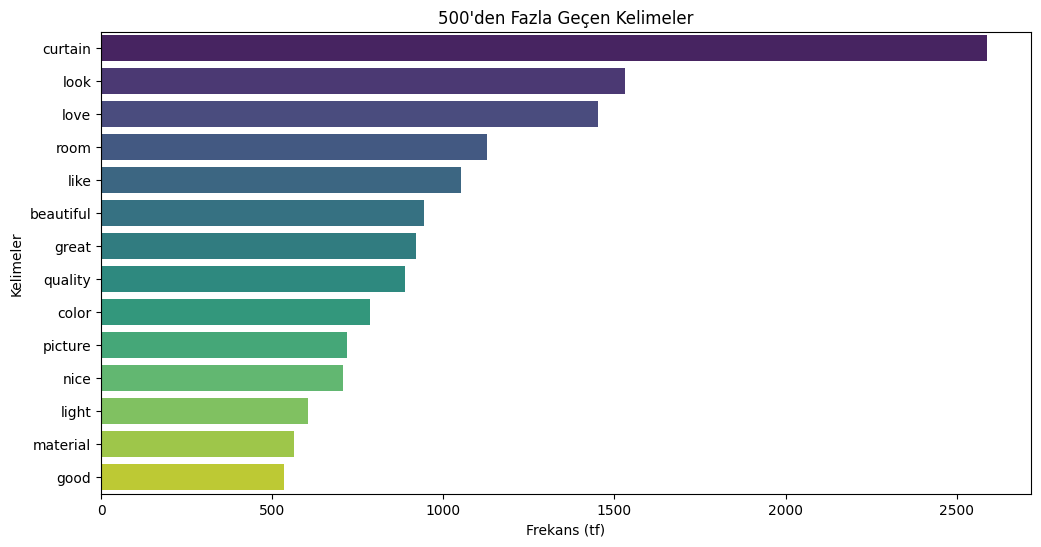

In [53]:
# Görselleşitirelim

plt.figure(figsize=(12, 6))
sns.barplot(
    x="tf",
    y="words",
    data=tf_top.sort_values("tf", ascending=False),
    palette="viridis",
)

plt.title("500'den Fazla Geçen Kelimeler")
plt.xlabel("Frekans (tf)")
plt.ylabel("Kelimeler")
plt.show()

In [54]:
# clean_words listelerini birlşetirelim tek bir string haline getir
text = " ".join([word for tokens in df["clean_words"] for word in tokens])

In [55]:
# WordCloud şablonunu belirle
wordcloud = WordCloud(
    width=800, height=400,
    background_color="white",
    colormap="viridis",
    max_words=200).generate(text)   # text ile generate et

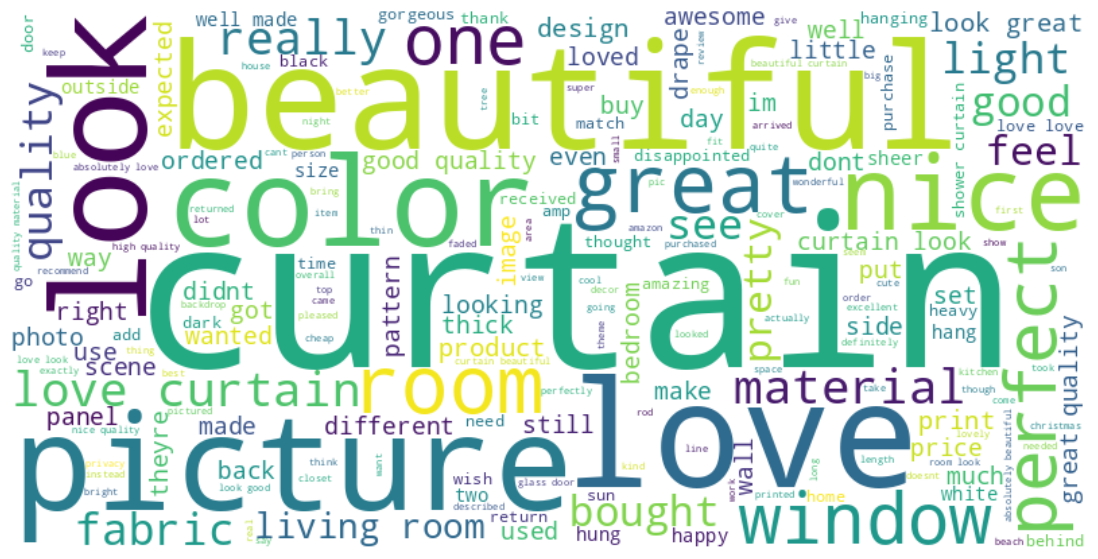

In [56]:
# Görselleştirme
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")   # grafiği görüntüle
plt.axis("off")   # eksemleri kapat
plt.show()

In [57]:
#########################################################
# 7. DUYGU ANALİZİ (SentimentIntensityAnalyzer)
#########################################################

In [58]:
# SentimentIntensityAnalyzer nesnesini oluşturalım
sia = SentimentIntensityAnalyzer()

In [59]:
# NaN değerleri boş string yap
df["Review"] = df["Review"].fillna("")

In [60]:
# Tüm gözlemler için polarity_scores hesaplayalım
df["polarity"] = df["Review"].apply(lambda x: sia.polarity_scores(x))
df["polarity"]

,polarity
0,"{'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp..."
1,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp..."
2,"{'neg': 0.0, 'neu': 0.749, 'pos': 0.251, 'comp..."
3,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,"{'neg': 0.0, 'neu': 0.699, 'pos': 0.301, 'comp..."
...,...
5606,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp..."
5607,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5608,"{'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'comp..."
5609,"{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound..."


In [61]:
# compound skorunu ayrı bir sütun olarak al
df["compound"] = df["polarity"].apply(lambda x : x["compound"])
df["compound"]

,compound
0,0.5719
1,0.4404
2,0.6908
3,0.0000
4,0.9042
...,...
5606,0.7650
5607,0.0000
5608,0.8070
5609,0.8402


In [62]:
# pos-neg ataması yap ve yeni sütun oluştur
df["sentiment"] = df["compound"].apply(lambda x: "pos" if x > 0 else "neg")

In [63]:
# Kontrol
df[["Review", "compound", "sentiment"]].head(10)

,Review,compound,sentiment
0,Happy with it,0.5719,pos
1,Good quality material however the panels are m...,0.4404,pos
2,Product was fun for bedroom windows.<br />Imag...,0.6908,pos
3,Lo unico que me gustaria es que sean un poco ...,0.0000,neg
4,Great bang for the buck I can't believe the qu...,0.9042,pos
5,Looks different then photo,0.0000,neg
6,Was exactly what i was looking for. Heavy mate...,0.6249,pos
7,"Looking at the picture, I thought these curtai...",0.9783,pos
8,Much whiter than I thought it would be and was...,0.0000,neg
9,These are curtains just as the picture shows. ...,0.7559,pos


In [64]:
#########################################################
# 8. TRAIN-TEST AYRIMI VE TF-IDF DÖNÜŞÜMÜ
#########################################################

In [65]:
X = df["Review"]    # Bağımsız değişken
y = df["sentiment"]    # Bağımlı değişken

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [67]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [68]:
# Train verisini fit et
tfidf.fit(X_train)

TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

In [69]:
# Train ve test verilerini transform edelim
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [70]:
# Boyut kontrolü
print("Train YF-IDF Shape: " , X_train_tfidf.shape)
print("Test YF-IDF Shape: " , X_test_tfidf.shape)

Train YF-IDF Shape:  (4488, 5000)
Test YF-IDF Shape:  (1123, 5000)


In [71]:
#########################################################
# 9. LOJİSTİK REGRESYON MODELİ
#########################################################

In [72]:
# Lojistik Regresyon Modelini oluşturulup train veri ile fit edelim
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [73]:
# Test verisi üzerinde tahmin
y_pred = lr_model.predict(X_test_tfidf)
print(y_pred)

['pos' 'pos' 'pos' ... 'pos' 'pos' 'pos']


In [74]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

         neg       0.90      0.43      0.58       200
         pos       0.89      0.99      0.94       923

    accuracy                           0.89      1123
   macro avg       0.89      0.71      0.76      1123
weighted avg       0.89      0.89      0.87      1123



In [75]:
# Cross-validation ile ortalama accuracy
cv_scores = cross_val_score(lr_model, X_train_tfidf, y_train, cv=5)
print("CV Scores: ", cv_scores)
print("CV Mean Score: ", cv_scores.mean())

CV Scores:  [0.87082405 0.8596882  0.87305122 0.86287625 0.86956522]
CV Mean Score:  0.8672009891918868


In [76]:
#########################################################
# 10. RANDOM FOREST MODELİ + GRIDSEARCH
#########################################################

In [77]:
# Random Forest modelini kuralım
rf_model = RandomForestClassifier(random_state=17)

In [78]:
rf_params = {"max_depth": [5, 8, None],
             "max_features" : [5, 7, "auto"],
             "min_samples_split": [2, 5],
             "n_estimators": [100, 200]}

In [79]:
rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/

In [80]:
# En iyi parametreleri çek
best_params = rf_best_grid.best_params_
print(best_params)

{'max_depth': None, 'max_features': 7, 'min_samples_split': 5, 'n_estimators': 100}


In [81]:
# Tüm veriyi TF-IDF ile vektörleştir
X_tfidf_all = tfidf.transform(X)  # tüm Review'ler

In [82]:
# Final RandomForest modeli (en iyi parametrelerle)
rf_final = RandomForestClassifier(**best_params, random_state=17)
rf_final.fit(X_tfidf_all, y)

RandomForestClassifier(max_features=7, min_samples_split=5, random_state=17)

In [83]:
# Tüm veri için cross-validation tahminleri
y_pred_cv = cross_val_predict(rf_final, X_tfidf_all, y, cv=5, n_jobs=-1)

# Classification report
print("Cross-Validation Classification Report:\n")
print(classification_report(y, y_pred_cv))

Cross-Validation Classification Report:

              precision    recall  f1-score   support

         neg       0.86      0.40      0.55      1011
         pos       0.88      0.99      0.93      4600

    accuracy                           0.88      5611
   macro avg       0.87      0.69      0.74      5611
weighted avg       0.88      0.88      0.86      5611



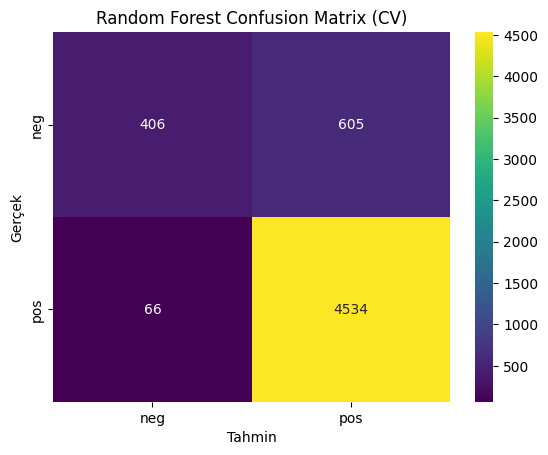

In [84]:
cm = confusion_matrix(y, y_pred_cv)  # y_train yerine y kullan
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=["neg","pos"], yticklabels=["neg","pos"])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Random Forest Confusion Matrix (CV)")
plt.show()


In [85]:
# Üsttedeki matrixte model pozitif yorumları çok yüksek doğrulukla yakalayabiliyor.
# Ancak negatif yorumlarda dengesizlik var. Negatif yorumların neredeyse yarıdan fazlası pozitif olarak tahmin edilmiş.
# Modelimize "pozitif  önyargılı" yorumlamaya meyilli diyebiliriz.

In [86]:
# Logistic Regression skorları
lr_acc = accuracy_score(y_test, y_pred)
lr_prec = precision_score(y_test, y_pred, pos_label="pos")
lr_rec = recall_score(y_test, y_pred, pos_label="pos")
lr_f1 = f1_score(y_test, y_pred, pos_label="pos")

# Random Forest skorları (cross-validation tahminlerinden)
rf_acc = accuracy_score(y, y_pred_cv)
rf_prec = precision_score(y, y_pred_cv, pos_label="pos")
rf_rec = recall_score(y, y_pred_cv, pos_label="pos")
rf_f1 = f1_score(y, y_pred_cv, pos_label="pos")

# DataFrame olarak sonuçları özetleyelim
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest (CV)"],
    "Accuracy": [lr_acc, rf_acc],
    "Precision": [lr_prec, rf_prec],
    "Recall": [lr_rec, rf_rec],
    "F1": [lr_f1, rf_f1]
})

print("\nModel Karşılaştırma Tablosu:\n")
print(results)


Model Karşılaştırma Tablosu:

                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.889581   0.888997  0.989166  0.936410
1   Random Forest (CV)  0.880413   0.882273  0.985652  0.931102


In [87]:
# Logistic Regression ->  Recall çok yüksek yani negatifleri kaçırmıyor ama yanlış pozitifleri fazla.
# Random Forest -> Precision daha yüksek yani yanlış pozitifleri azaltıyor, daha dengeli.